In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('extracted_v2.csv')

In [4]:
df.shape

(24573, 12)

In [5]:
df = df.drop(columns=['Unnamed: 0','url','comments','num_comments','created','subreddit_y','post_id'])
df.tail()

title  score      id subreddit_x  \
24568  South Bronx, early 80’s    284  e3eyc8         nyc   
24569  South Bronx, early 80’s    284  e3eyc8         nyc   
24570  South Bronx, early 80’s    284  e3eyc8         nyc   
24571  South Bronx, early 80’s    284  e3eyc8         nyc   
24572  South Bronx, early 80’s    284  e3eyc8         nyc   

                                                 comment  
24568                             Lovin' the Stan Smiths  
24569  Gotta be the 80s to get away with pants that s...  
24570                              That was a pro-photo.  
24571         Total hellhole. Thank god Rudy saved us /s  
24572  Proof positive that being gay wasn’t invented ...

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
stops = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
def clean(s):
    s = s.lower()
    s_token = tokenizer.tokenize(s)
    s_filtered = [w for w in s_token if not w in stops]
    return s_filtered

In [7]:
df['comment_tokenized'] = df['comment'].apply(clean)

In [8]:
from collections import Counter

def get_counts(s):
    return Counter(s)

In [9]:
df['word_counts'] = df['comment_tokenized'].apply(get_counts)

In [10]:
president_counts = {'warren':0, 'biden':0, 'sanders':0, 'buttigieg':0, 'yang':0, 'trump':0, 'bloomberg':0}
issue_counts = {'guns':0, 'wealth':0, 'immigration':0, 'foreign':0, 'weed':0, 
                'climate':0, 'tech':0, 'jobs':0, 'economy':0, 'nationalism':0, 'china':0, 'healthcare':0}
def count_attributes(s):
    for key in s.keys():
        if key in president_counts:
            president_counts[key] += 1
        if key in issue_counts:
            issue_counts[key] += 1

In [11]:
df['word_counts'].apply(count_attributes)
print(president_counts)

{'warren': 574, 'biden': 662, 'sanders': 347, 'buttigieg': 191, 'yang': 441, 'trump': 2561, 'bloomberg': 192}


In [12]:
df['word_counts'].apply(count_attributes)
print(issue_counts)

{'guns': 222, 'wealth': 498, 'immigration': 172, 'foreign': 516, 'weed': 58, 'climate': 624, 'tech': 108, 'jobs': 336, 'economy': 566, 'nationalism': 40, 'china': 476, 'healthcare': 378}


In [13]:
presidents = sorted(president_counts, key=president_counts.get, reverse=True)
presidents_num = sorted(np.fromiter(president_counts.values(), dtype=float), reverse=True)

In [14]:
candidates_df = pd.DataFrame({'Candidate': presidents, 'Frequency': presidents_num})
candidates_df

Candidate  Frequency
0      trump     5122.0
1      biden     1324.0
2     warren     1148.0
3       yang      882.0
4    sanders      694.0
5  bloomberg      384.0
6  buttigieg      382.0

In [15]:
candidate_comentions = np.zeros((7, 7))

def count_comentions(s):
    for i in range(7):
        for j in range(7):
            if presidents[i] in s.keys() and presidents[j] in s.keys():
                candidate_comentions[i][j]+=1
                
temp = df['word_counts'].apply(count_comentions)

In [16]:
candidate_comentions
df_candidate_comentions = pd.DataFrame(candidate_comentions, columns=presidents, index=presidents)
df_candidate_comentions

trump  biden  warren   yang  sanders  bloomberg  buttigieg
trump      2561.0  179.0   104.0   37.0     64.0       31.0       39.0
biden       179.0  662.0   192.0   55.0    109.0       42.0       86.0
warren      104.0  192.0   574.0   69.0    174.0       39.0       86.0
yang         37.0   55.0    69.0  441.0     31.0       14.0       25.0
sanders      64.0  109.0   174.0   31.0    347.0       24.0       59.0
bloomberg    31.0   42.0    39.0   14.0     24.0      192.0       21.0
buttigieg    39.0   86.0    86.0   25.0     59.0       21.0      191.0

In [17]:
lifts = np.zeros((7, 7))
N = len(df)
for i in range(7):
    count1 = presidents_num[i]
    for j in range(7):
        count2 = presidents_num[j]
        denom = count1 * count2
        numer = candidate_comentions[i][j]
        lifts[i][j] = (numer/denom) * N
np.set_printoptions(precision = 1)
df_lifts = pd.DataFrame(lifts, columns=presidents, index=presidents)
df_lifts

trump     biden     warren       yang    sanders  bloomberg  \
trump      2.398770  0.648610   0.434620   0.201257   0.442424   0.387301   
biden      0.648610  9.279834   3.104056   1.157349   2.914991   2.029964   
warren     0.434620  3.104056  10.702526   1.674545   5.366685   2.173951   
yang       0.201257  1.157349   1.674545  13.930272   1.244491   1.015749   
sanders    0.442424  2.914991   5.366685   1.244491  17.703890   2.212986   
bloomberg  0.387301  2.029964   2.173951   1.015749   2.212986  31.996094   
buttigieg  0.489801  4.178355   4.818938   1.823334   5.468741   3.517895   

           buttigieg  
trump       0.489801  
biden       4.178355  
warren      4.818938  
yang        1.823334  
sanders     5.468741  
bloomberg   3.517895  
buttigieg  32.163613

# Make MDS Plot

In [18]:
dissimilarity = lifts
for i in range(7):
    for j in range(7):
        if i == j:
            dissimilarity[i][j]=0
        else:
            dissimilarity[i][j] = 1/lifts[i][j]
        
df_dissimilarity = pd.DataFrame(dissimilarity, columns=presidents, index=presidents)
df_dissimilarity

trump     biden    warren      yang   sanders  bloomberg  \
trump      0.000000  1.541758  2.300859  4.968763  2.260273   2.581968   
biden      1.541758  0.000000  0.322159  0.864044  0.343054   0.492620   
warren     2.300859  0.322159  0.000000  0.597177  0.186335   0.459992   
yang       4.968763  0.864044  0.597177  0.000000  0.803541   0.984495   
sanders    2.260273  0.343054  0.186335  0.803541  0.000000   0.451878   
bloomberg  2.581968  0.492620  0.459992  0.984495  0.451878   0.000000   
buttigieg  2.041645  0.239329  0.207515  0.548446  0.182857   0.284261   

           buttigieg  
trump       2.041645  
biden       0.239329  
warren      0.207515  
yang        0.548446  
sanders     0.182857  
bloomberg   0.284261  
buttigieg   0.000000

<Figure size 640x640 with 0 Axes>

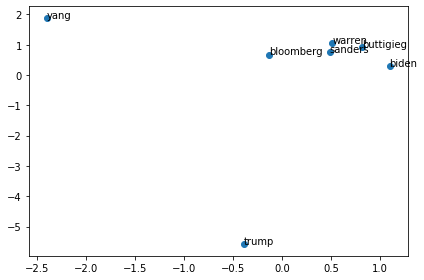

<Figure size 720x720 with 0 Axes>

In [107]:
from sklearn.manifold import MDS
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
mds = MDS(dissimilarity='euclidean')
coords = mds.fit_transform(dissimilarity)

x,y = coords.T

fig, ax=plt.subplots()
plt.figure(figsize=(10,10))
ax.scatter(x,y)

for i, txt in enumerate(presidents):
    ax.annotate(txt, (x[i],y[i]))

# Task C Type Shit

In [20]:
from itertools import chain
pd.set_option('display.max_rows', None)
all_words = pd.Series(chain(*list(df['word_counts'])))
word_frequency = all_words.value_counts()
word_frequency

people                                                                                                                                              3317
like                                                                                                                                                3301
would                                                                                                                                               2611
trump                                                                                                                                               2561
one                                                                                                                                                 2288
think                                                                                                                                               2097
get                                                                               

In [21]:
from nltk import ngrams
from nltk.tokenize import MWETokenizer
import re
tokenizer2 = MWETokenizer(r'\w+')

tuples = [('gun','control'), ('school','shooting'), ('second','amendment'), ('gun','buyback'), ('assult','rifle'), # guns
          ('universal','basic','income'), ('income','disparity'), ('glass','ceiling'), ('wage','gap'), # wealth gap
          ('illegal','alien'), ('border','control'), ('border','security'), # immigration
          ('global','policy'), # foreign policy
          ('global','warming'), ('global','cooling'), ('paris','agreement'), # climate crisis
          ('stock','market'), ('trade','deals'), ('trade','deal'), ('trade','war'), ('stock','prices'), # economy
          ('make','america','great','again'), ('keep','america','great'), ('america','first'), # nationalism
          ('medicare','for','all'), ('socialized','medicine'), ('expand', 'medicaid'), ('single','payer'), ('insurance','companies') # healthcare
          ]

for tup in tuples:
    tokenizer2.add_mwe(tup)
    
def clean_no_stop(s):
    s = s.lower()
    s = re.sub(r'[^\w\s\d]', '', s)
    s_token = tokenizer2.tokenize(s.split())
    return s_token

df['token_no_stop']=df['comment'].apply(clean_no_stop)

In [22]:
gun_phrases = ['firearm','firearms','gat','heater','ak','ak47','ak-47','ar','ar15','ar-15','shooting','shooter','gun_control', 'second_amendment', 'gun_buyback', 'assault_rifle']
wealth_phrases = ['bourgeoisie', 'poor', 'billionaire', 'billionaires', 'wealthy', 'rich', 'universal_basic_income', 'income_disparity', 'glass_ceiling', 'wage_gap']
immigration_phrases = ['immigrants', 'immigrant', 'refugee', 'refugees', 'wall','illegal_alien','border_security','border_control']
foreign_phrases = ['global_policy', 'globalization', 'allies','ally', 'nato', 'un']
weed_phrases = ['marijuana', 'pot']
climate_phrases = ['weather', 'carbon','global_warming', 'global_cooling', 'paris_agreement']
tech_phrases = ['facebook', 'amazon', 'google']
economy_phrases = ['inflation', 'fiscal', 'currency', 'dollar', 'debt', 'deficit', 'stock_market', 'trade_deal', 'trade_deals', 'trade_war', 'stock_prices', 'unemployment']
nationalism_phrases = ['maga', 'kag','make_america_great_again', 'keep_america_great', 'america_first']
healthcare_phrases = ['doctors', 'health', 'medicine', 'medical', 'medicare_for_all', 'socialized_medicine', 'expand_medicaid', 'single_payer', 'insurance_companies']
dumb_phrases = ['stupid','idiot','unintelligent','imbecile','retard'] # dumb

def grams_to_words(s):
    for i in range(len(s)):
        if s[i] in gun_phrases:
            s[i] = 'gun'
        elif s[i] in wealth_phrases:
            s[i] = 'wealth'
        elif s[i] in immigration_phrases:
            s[i] = 'immigration'
        elif s[i] in foreign_phrases:
            s[i] = 'foreign'
        elif s[i] in weed_phrases:
            s[i] = 'weed'
        elif s[i] in climate_phrases:
            s[i] = 'climate'
        elif s[i] in tech_phrases:
            s[i] = 'tech'
        elif s[i] in economy_phrases:
            s[i] = 'economy'
        elif s[i] in nationalism_phrases:
            s[i] = 'nationalism'
        elif s[i] in healthcare_phrases:
            s[i] = 'healthcare'
        elif s[i] in dumb_phrases:
            s[i] = 'dumb'
    return s

In [23]:
df['token_no_stop'] = df['token_no_stop'].apply(grams_to_words)

In [24]:
df['word_counts_v2'] = df['token_no_stop'].apply(get_counts)

In [25]:
president_counts = {'warren':0, 'biden':0, 'sanders':0, 'buttigieg':0, 'yang':0, 'trump':0, 'bloomberg':0}
issue_counts = {'guns':0, 'wealth':0, 'immigration':0, 'foreign':0, 'weed':0, 
                'climate':0, 'tech':0, 'jobs':0, 'economy':0, 'nationalism':0, 'china':0, 'healthcare':0, 'dumb':0}
def count_attributes(s):
    for key in s.keys():
        if key in president_counts:
            president_counts[key] += 1
        if key in issue_counts:
            issue_counts[key] += 1

In [26]:
df['word_counts_v2'].apply(count_attributes)
print(president_counts)

{'warren': 507, 'biden': 587, 'sanders': 308, 'buttigieg': 168, 'yang': 409, 'trump': 2343, 'bloomberg': 178}


In [27]:
df['word_counts'].apply(count_attributes)
print(issue_counts)

{'guns': 222, 'wealth': 1212, 'immigration': 352, 'foreign': 643, 'weed': 102, 'climate': 699, 'tech': 360, 'jobs': 332, 'economy': 784, 'nationalism': 71, 'china': 462, 'healthcare': 643, 'dumb': 580}


In [28]:
issues = sorted(issue_counts, key=issue_counts.get, reverse=True)
issues_num = sorted(np.fromiter(issue_counts.values(), dtype=float), reverse=True)

In [29]:
issues_df = pd.DataFrame({'Candidate/Issue': issues, 'Frequency': issues_num})
issues_df

Candidate/Issue  Frequency
0           wealth     1212.0
1          economy      784.0
2          climate      699.0
3          foreign      643.0
4       healthcare      643.0
5             dumb      580.0
6            china      462.0
7             tech      360.0
8      immigration      352.0
9             jobs      332.0
10            guns      222.0
11            weed      102.0
12     nationalism       71.0

In [30]:
candidates_issues = presidents + issues
candidates_issues_num = presidents_num + issues_num
print(candidates_issues_num)

[5122.0, 1324.0, 1148.0, 882.0, 694.0, 384.0, 382.0, 1212.0, 784.0, 699.0, 643.0, 643.0, 580.0, 462.0, 360.0, 352.0, 332.0, 222.0, 102.0, 71.0]


In [31]:
candidates_issues_comentions = np.zeros((20,20))

def count_comentions_v2(s):
    for i in range(20):
        for j in range(20):
            if candidates_issues[i] in s.keys() and candidates_issues[j] in s.keys():
                candidates_issues_comentions[i][j]+=1
trash = df['word_counts_v2'].apply(count_comentions_v2)

In [32]:
df_candidates_issues_comentions = pd.DataFrame(candidates_issues_comentions, columns=candidates_issues, index=candidates_issues)

In [33]:
df_candidates_issues_comentions

trump  biden  warren   yang  sanders  bloomberg  buttigieg  \
trump        2343.0  147.0    88.0   29.0     52.0       23.0       31.0   
biden         147.0  587.0   163.0   48.0     92.0       37.0       71.0   
warren         88.0  163.0   507.0   60.0    149.0       29.0       72.0   
yang           29.0   48.0    60.0  409.0     29.0       12.0       20.0   
sanders        52.0   92.0   149.0   29.0    308.0       21.0       50.0   
bloomberg      23.0   37.0    29.0   12.0     21.0      178.0       19.0   
buttigieg      31.0   71.0    72.0   20.0     50.0       19.0      168.0   
wealth        117.0   34.0    61.0   24.0     29.0       29.0       12.0   
economy        86.0   16.0    31.0   10.0     18.0        5.0        8.0   
climate        38.0   10.0    13.0    6.0     10.0        2.0        2.0   
foreign       103.0   28.0    10.0    9.0      8.0        0.0        7.0   
healthcare     55.0   22.0    40.0   11.0     30.0        3.0       13.0   
dumb           85.0   10.0    13.0    3.0      6.0        6.0        2.0   
china          37.0    8.0     6.0    3.0      3.0        1.0        1.0   
tech           52.0    7.0    13.0    6.0      7.0        3.0        2.0   
immigration    49.0   11.0    17.0    9.0     13.0        3.0        4.0   
jobs           22.0    3.0     7.0    4.0      4.0        1.0        2.0   
guns           18.0    5.0     6.0    3.0      2.0        1.0        4.0   
weed            8.0    7.0     5.0    3.0      3.0        3.0        0.0   
nationalism    10.0    1.0     0.0    0.0      0.0        0.0        0.0   

             wealth  economy  climate  foreign  healthcare   dumb  china  \
trump         117.0     86.0     38.0    103.0        55.0   85.0   37.0   
biden          34.0     16.0     10.0     28.0        22.0   10.0    8.0   
warren         61.0     31.0     13.0     10.0        40.0   13.0    6.0   
yang           24.0     10.0      6.0      9.0        11.0    3.0    3.0   
sanders        29.0     18.0     10.0      8.0        30.0    6.0    3.0   
bloomberg      29.0      5.0      2.0      0.0         3.0    6.0    1.0   
buttigieg      12.0      8.0      2.0      7.0        13.0    2.0    1.0   
wealth        963.0     91.0     36.0     26.0        82.0   32.0   15.0   
economy        91.0    501.0     25.0     43.0        59.0   11.0   37.0   
climate        36.0     25.0    387.0     13.0        23.0   12.0   13.0   
foreign        26.0     43.0     13.0    385.0        13.0    6.0   26.0   
healthcare     82.0     59.0     23.0     13.0       454.0   18.0    4.0   
dumb           32.0     11.0     12.0      6.0        18.0  451.0    7.0   
china          15.0     37.0     13.0     26.0         4.0    7.0  224.0   
tech           20.0     21.0      8.0      5.0        12.0    7.0    8.0   
immigration    35.0     25.0      9.0     15.0        18.0   13.0    7.0   
jobs           29.0     33.0     11.0      9.0        17.0    6.0    8.0   
guns           12.0      8.0      2.0      8.0         7.0   10.0    2.0   
weed            7.0      3.0      3.0      2.0         8.0    4.0    2.0   
nationalism     5.0      6.0      2.0      2.0         1.0    1.0    2.0   

              tech  immigration   jobs   guns  weed  nationalism  
trump         52.0         49.0   22.0   18.0   8.0         10.0  
biden          7.0         11.0    3.0    5.0   7.0          1.0  
warren        13.0         17.0    7.0    6.0   5.0          0.0  
yang           6.0          9.0    4.0    3.0   3.0          0.0  
sanders        7.0         13.0    4.0    2.0   3.0          0.0  
bloomberg      3.0          3.0    1.0    1.0   3.0          0.0  
buttigieg      2.0          4.0    2.0    4.0   0.0          0.0  
wealth        20.0         35.0   29.0   12.0   7.0          5.0  
economy       21.0         25.0   33.0    8.0   3.0          6.0  
climate        8.0          9.0   11.0    2.0   3.0          2.0  
foreign        5.0         15.0    9.0    8.0   2.0          2.0  
healthcare    12

In [34]:
issue_lifts = np.zeros((20, 20))
N = len(df)
for i in range(20):
    count1 = candidates_issues_num[i]
    for j in range(20):
        count2 = candidates_issues_num[j]
        denom = count1 * count2
        numer = candidates_issues_comentions[i][j]
        issue_lifts[i][j] = (numer/denom) * N
np.set_printoptions(precision = 1)
df_issue_lifts = pd.DataFrame(issue_lifts, columns = candidates_issues, index = candidates_issues)
df_issue_lifts

trump     biden    warren       yang    sanders  bloomberg  \
trump        2.194580  0.532657  0.367756   0.157742   0.359470   0.287353   
biden        0.532657  8.228493  2.635214   1.010050   2.460359   1.788301   
warren       0.367756  2.635214  9.453277   1.456126   4.595609   1.616527   
yang         0.157742  1.010050  1.456126  12.919459   1.164201   0.870642   
sanders      0.359470  2.460359  4.595609   1.164201  15.714116   1.936363   
bloomberg    0.287353  1.788301  1.616527   0.870642   1.936363  29.663045   
buttigieg    0.389329  3.449572  4.034460   1.458667   4.634526   3.182857   
wealth       0.463129  0.520651  1.077317   0.551694   0.847216   1.531166   
economy      0.526261  0.378769  0.846373   0.355364   0.812934   0.408113   
climate      0.260810  0.265517  0.398091   0.239146   0.506549   0.183096   
foreign      0.768502  0.808197  0.332894   0.389961   0.440532   0.000000   
healthcare   0.410365  0.635012  1.331574   0.476619   1.651996   0.298564   
dumb         0.703088  0.319994  0.479768   0.144106   0.366287   0.661988   
china        0.384219  0.321380  0.277988   0.180913   0.229921   0.138511   
tech         0.692978  0.360882  0.772960   0.464342   0.688485   0.533268   
immigration  0.667839  0.579990  1.033767   0.712343   1.307674   0.545388   
jobs         0.317909  0.167708  0.451311   0.335669   0.426600   0.192748   
guns         0.388990  0.418011  0.578515   0.376494   0.318989   0.288253   
weed         0.376278  1.273703  1.049267   0.819428   1.041405   1.882123   
nationalism  0.675710  0.261404  0.000000   0.000000   0.000000   0.000000   

             buttigieg     wealth    economy    climate    foreign  \
trump         0.389329   0.463129   0.526261   0.260810   0.768502   
biden         3.449572   0.520651   0.378769   0.265517   0.808197   
warren        4.034460   1.077317   0.846373   0.398091   0.332894   
yang          1.458667   0.551694   0.355364   0.239146   0.389961   
sanders       4.634526   0.847216   0.812934   0.506549   0.440532   
bloomberg     3.182857   1.531166   0.408113   0.183096   0.000000   
buttigieg    28.290507   0.636903   0.656400   0.184055   0.700296   
wealth        0.636903  16.109395   2.353319   1.044193   0.819819   
economy       0.656400   2.353319  20.029208   1.120998   2.096040   
climate       0.184055   1.044193   1.120998  19.463225   0.710744   
foreign       0.700296   0.819819   2.096040   0.710744  22.882157   
healthcare    1.300550   2.585583   2.875962   1.257471   0.772644   
dumb          0.221818   1.118607   0.594438   0.727335   0.395340   
china         0.139236   0.658271   2.510163   0.989196   2.150694   
tech          0.357373   1.126375   1.828348   0.781211   0.530780   
immigration   0.730991   2.015956   2.226073   0.898837   1.628530   
jobs          0.387513   1.770987   3.115430   1.164758   1.035981   
guns          1.159049   1.095933   1.129482   0.316707   1.377159   
weed          0.000000   1.391405   0.921856   1.033956   0.749337   
nationalism   0.000000   1.427799   2.648714   0.990268   1.076512   

             healthcare       dumb      china       tech  immigration  \
trump          0.410365   0.703088   0.384219   0.692978     0.667839   
biden          0.635012   0.319994   0.321380   0.360882     0.579990   
warren         1.331574   0.479768   0.277988   0.772960     1.033767   
yang           0.476619   0.144106   0.180913   0.464342     0.712343   
sanders        1.651996   0.366287   0.229921   0.688485     1.307674   
bloomberg      0.298564   0.661988   0.138511   0.533268     0.545388   
buttigieg      1.300550   0.221818   0.139236   0.357373     0.730991   
wealth         2.585583   1.118607   0.658271   1.126375     2.015956   
economy        2.875962   0.594438   2.510163   1.828348     2.226073   
climate        1.257471   0.727335   0.989196   0.781211     0.898837   
foreign        0.772644   0.395340   2.150694   0.530780     1.628530   
healthcare    26.983115   1.18

In [110]:
df_issue_lifts2 = df_issue_lifts.drop(presidents, axis=1)[:7].sort_values(by='wealth', ascending=False)

In [111]:
df_issue_lifts2

wealth   economy   climate   foreign  healthcare      dumb  \
bloomberg  1.531166  0.408113  0.183096  0.000000    0.298564  0.661988   
warren     1.077317  0.846373  0.398091  0.332894    1.331574  0.479768   
sanders    0.847216  0.812934  0.506549  0.440532    1.651996  0.366287   
buttigieg  0.636903  0.656400  0.184055  0.700296    1.300550  0.221818   
yang       0.551694  0.355364  0.239146  0.389961    0.476619  0.144106   
biden      0.520651  0.378769  0.265517  0.808197    0.635012  0.319994   
trump      0.463129  0.526261  0.260810  0.768502    0.410365  0.703088   

              china      tech  immigration      jobs      guns      weed  \
bloomberg  0.138511  0.533268     0.545388  0.192748  0.288253  1.882123   
warren     0.277988  0.772960     1.033767  0.451311  0.578515  1.049267   
sanders    0.229921  0.688485     1.307674  0.426600  0.318989  1.041405   
buttigieg  0.139236  0.357373     0.730991  0.387513  1.159049  0.000000   
yang       0.180913  0.464342     0.712343  0.335669  0.376494  0.819428   
biden      0.321380  0.360882     0.579990  0.167708  0.418011  1.273703   
trump      0.384219  0.692978     0.667839  0.317909  0.388990  0.376278   

           nationalism  
bloomberg     0.000000  
warren        0.000000  
sanders       0.000000  
buttigieg     0.000000  
yang          0.000000  
biden         0.261404  
trump         0.675710

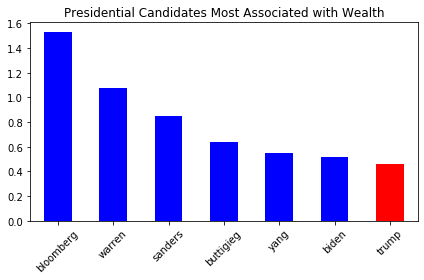

In [117]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.tight_layout()
colors = ['blue','blue','blue','blue','blue','blue','red']
df_issue_lifts2['wealth'].plot(kind='bar', color=colors)
plt.title('Presidential Candidates Most Associated with Wealth')
plt.xticks(rotation='45')
plt.savefig('wealth_graph',dpi=500)

# Make DMS Plot for Issues Comentions

In [38]:
issue_lifts3 = issue_lifts[7:,7:]
issue_lifts3

array([[ 16.1,   2.4,   1. ,   0.8,   2.6,   1.1,   0.7,   1.1,   2. ,
          1.8,   1.1,   1.4,   1.4],
       [  2.4,  20. ,   1.1,   2.1,   2.9,   0.6,   2.5,   1.8,   2.2,
          3.1,   1.1,   0.9,   2.6],
       [  1. ,   1.1,  19.5,   0.7,   1.3,   0.7,   1. ,   0.8,   0.9,
          1.2,   0.3,   1. ,   1. ],
       [  0.8,   2.1,   0.7,  22.9,   0.8,   0.4,   2.2,   0.5,   1.6,
          1. ,   1.4,   0.7,   1.1],
       [  2.6,   2.9,   1.3,   0.8,  27. ,   1.2,   0.3,   1.3,   2. ,
          2. ,   1.2,   3. ,   0.5],
       [  1.1,   0.6,   0.7,   0.4,   1.2,  32.9,   0.6,   0.8,   1.6,
          0.8,   1.9,   1.7,   0.6],
       [  0.7,   2.5,   1. ,   2.2,   0.3,   0.6,  25.8,   1.2,   1.1,
          1.3,   0.5,   1. ,   1.5],
       [  1.1,   1.8,   0.8,   0.5,   1.3,   0.8,   1.2,  58. ,   1.6,
          1.2,   0. ,   0.7,   1.9],
       [  2. ,   2.2,   0.9,   1.6,   2. ,   1.6,   1.1,   1.6,  52.8,
          2.3,   1.6,   2.7,   2. ],
       [  1.8,   3.1,   1.2,

In [46]:
dissimilarity3 = issue_lifts3
for i in range(13):
    for j in range(13):
        if i == j:
            dissimilarity3[i][j] = 0
        else:
            dissimilarity3[i][j] = 1/issue_lifts3[i][j]
dissimilarity3 = np.nan_to_num(dissimilarity3)
        
df_dissimilarity3 = pd.DataFrame(dissimilarity3, columns=issues, index=issues)
df_dissimilarity3 = df_dissimilarity3.fillna(0)

In [47]:
df_dissimilarity3

wealth   economy   climate   foreign  healthcare      dumb  \
wealth       0.000000  2.353319  1.044193  0.819819    2.585583  1.118607   
economy      2.353319  0.000000  1.120998  2.096040    2.875962  0.594438   
climate      1.044193  1.120998  0.000000  0.710744    1.257471  0.727335   
foreign      0.819819  2.096040  0.710744  0.000000    0.772644  0.395340   
healthcare   2.585583  2.875962  1.257471  0.772644    0.000000  1.186019   
dumb         1.118607  0.594438  0.727335  0.395340    1.186019  0.000000   
china        0.658271  2.510163  0.989196  2.150694    0.330876  0.641928   
tech         1.126375  1.828348  0.781211  0.530780    1.273872  0.823807   
immigration  2.015956  2.226073  0.898837  1.628530    1.954236  1.564699   
jobs         1.770987  3.115430  1.164758  1.035981    1.956852  0.765673   
guns         1.095933  1.129482  0.316707  1.377159    1.205015  1.908434   
weed         1.391405  0.921856  1.033956  0.749337    2.997347  1.661460   
nationalism  1.427799  2.648714  0.990268  1.076512    0.538256  0.596722   

                china      tech  immigration      jobs      guns      weed  \
wealth       0.658271  1.126375     2.015956  1.770987  1.095933  1.391405   
economy      2.510163  1.828348     2.226073  3.115430  1.129482  0.921856   
climate      0.989196  0.781211     0.898837  1.164758  0.316707  1.033956   
foreign      2.150694  0.530780     1.628530  1.035981  1.377159  0.749337   
healthcare   0.330876  1.273872     1.954236  1.956852  1.205015  2.997347   
dumb         0.641928  0.823807     1.564699  0.765673  1.908434  1.661460   
china        0.000000  1.181962     1.057722  1.281646  0.479174  1.042908   
tech         1.181962  0.000000     1.551326  1.233584  0.000000  0.669199   
immigration  1.057722  1.551326     0.000000  2.312971  1.572290  2.737634   
jobs         1.281646  1.233584     2.312971  0.000000  0.666802  0.000000   
guns         0.479174  0.000000     1.572290  0.666802  0.000000  2.170376   
weed         1.042908  0.669199     2.737634  0.000000  2.170376  0.000000   
nationalism  1.498262  1.922770     1.966469  1.042466  0.000000  0.000000   

             nationalism  
wealth          1.427799  
economy         2.648714  
climate         0.990268  
foreign         1.076512  
healthcare      0.538256  
dumb            0.596722  
china           1.498262  
tech            1.922770  
immigration     1.966469  
jobs            1.042466  
guns            0.000000  
weed            0.000000  
nationalism     0.000000

In [44]:
# from numpy import inf
# dissimilarity3[dissimilarity3 == -inf] = 0

<Figure size 640x640 with 0 Axes>

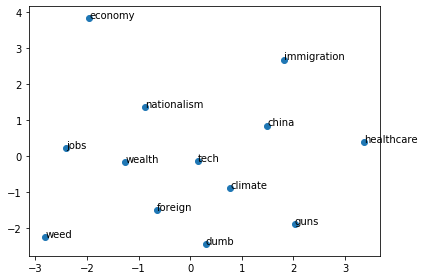

<Figure size 720x720 with 0 Axes>

In [106]:
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
mds = MDS(dissimilarity='euclidean')
coords = mds.fit_transform(dissimilarity3)

x,y = coords.T

fig, ax=plt.subplots()
plt.figure(figsize=(10,10))
ax.scatter(x,y)

for i, txt in enumerate(issues):
    ax.annotate(txt, (x[i],y[i]))

In [49]:
def candidate_flags(s, candidate):
    value = 0
    for key in s.keys():
        if key in president_counts:
            if key == candidate:
                value = 1
            else:
                value = 0
    return value

In [50]:
for president in presidents:
    df[president] = df['word_counts'].apply(candidate_flags, candidate=president)

In [51]:
def issue_flags(s, issue):
    value = 0
    for key in s.keys():
        if key in issue_counts:
            if key == issue:
                value = 1
            else:
                value = 0
    return value

In [52]:
for issue in issues:
    df[issue] = df['word_counts_v2'].apply(issue_flags, issue=issue)

In [53]:
df.head()

title  score      id  \
0                                 Community Comments     23  dztn6a   
1                                 Community Comments     23  dztn6a   
2                                 Community Comments     23  dztn6a   
3                                 Community Comments     23  dztn6a   
4  US Federal Reserve considers letting inflation...      3  e57z03   

  subreddit_x                                            comment  \
0  Capitalism                                          [deleted]   
1  Capitalism  Hey, if you need mods i am willing to be one. ...   
2  Capitalism  I have tagged several posts as the spam that t...   
3  Capitalism  laissez-faire moderating: usually better than ...   
4  Capitalism  They're printing money- they probably fuckin s...   

                                   comment_tokenized  \
0                                          [deleted]   
1  [hey, need, mods, willing, one, prior, moving,...   
2  [tagged, several, posts, spam, r, libertariani...   
3  [laissez, faire, moderating, usually, better, ...   
4  [printing, money, probably, fuckin, let, infla...   

                                         word_counts  \
0                                     {'deleted': 1}   
1  {'hey': 1, 'need': 1, 'mods': 1, 'willing': 1,...   
2  {'tagged': 1, 'several': 1, 'posts': 1, 'spam'...   
3  {'laissez': 1, 'faire': 1, 'moderating': 1, 'u...   
4  {'printing': 1, 'money': 1, 'probably': 1, 'fu...   

                                       token_no_stop  \
0                                          [deleted]   
1  [hey, if, you, need, mods, i, am, willing, to,...   
2  [i, have, tagged, several, posts, as, the, spa...   
3  [laissezfaire, moderating, usually, better, th...   
4  [theyre, printing, money, they, probably, fuck...   

                                      word_counts_v2  trump  biden  warren  \
0                                     {'deleted': 1}      0      0       0   
1  {'hey': 1, 'if': 1, 'you': 1, 'need': 1, 'mods...      0      0       0   
2  {'i': 2, 'have': 1, 'tagged': 1, 'several': 1,...      0      0       0   
3  {'laissezfaire': 1, 'moderating': 1, 'usually'...      0      0       0   
4  {'theyre': 1, 'printing': 1, 'money': 1, 'they...      0      0       0   

   yang  sanders  bloomberg  buttigieg  wealth  economy  climate  foreign  \
0     0        0          0          0       0        0        0        0   
1     0        0          0          0       0        0        0        0   
2     0        0          0          0       0        0        0        0   
3     0        0          0          0       0        0        0        0   
4     0        0          0          0       0        1        0        0   

   healthcare  dumb  china  tech  immigration  jobs  guns  weed  nationalism  
0           0     0      0     0            0     0     0     0            0  
1           0     0      0     0            0     0     0     0            0  
2           0     0      0     0            0     0     0     0            0  
3           0     0      0     0            0     0     0     0            0  
4           0     0      0     0            0     0     0     0            0

In [54]:
df['clean_comment'] = df['comment'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['clean_comment'] = df['clean_comment'].str.replace('[^\w\s]','')
df['clean_comment'] = df['clean_comment'].str.replace('[\d]','')
df['clean_comment'] = df['clean_comment'].apply(lambda x: " ".join(x for x in x.split() if x not in stops))

In [55]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['clean_comment'] = df['clean_comment'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [56]:
from textblob import TextBlob

def sentiment(s):
    return TextBlob(s).sentiment[0]

In [57]:
df['sentiment_score'] = df['clean_comment'].apply(sentiment)

In [58]:
overall = ['overall']
cols = issues + overall
pd.DataFrame(index=presidents, columns=cols)

wealth economy climate foreign healthcare dumb china tech  \
trump        NaN     NaN     NaN     NaN        NaN  NaN   NaN  NaN   
biden        NaN     NaN     NaN     NaN        NaN  NaN   NaN  NaN   
warren       NaN     NaN     NaN     NaN        NaN  NaN   NaN  NaN   
yang         NaN     NaN     NaN     NaN        NaN  NaN   NaN  NaN   
sanders      NaN     NaN     NaN     NaN        NaN  NaN   NaN  NaN   
bloomberg    NaN     NaN     NaN     NaN        NaN  NaN   NaN  NaN   
buttigieg    NaN     NaN     NaN     NaN        NaN  NaN   NaN  NaN   

          immigration jobs guns weed nationalism overall  
trump             NaN  NaN  NaN  NaN         NaN     NaN  
biden             NaN  NaN  NaN  NaN         NaN     NaN  
warren            NaN  NaN  NaN  NaN         NaN     NaN  
yang              NaN  NaN  NaN  NaN         NaN     NaN  
sanders           NaN  NaN  NaN  NaN         NaN     NaN  
bloomberg         NaN  NaN  NaN  NaN         NaN     NaN  
buttigieg         NaN  NaN  NaN  NaN         NaN     NaN

In [59]:
mask = (df['trump'] == 1) & (df['dumb'] == 1)
df[mask]['sentiment_score'].mean()

-0.13920367216092935

In [60]:
big_list = []
for i in presidents:
    small_list = []
    for j in issues:
        mask = (df[i] == 1) & (df[j] == 1)
        small_list.append(df[mask]['sentiment_score'].mean())
    big_list.append(small_list)
big_list        

[[0.08771823674787499,
  0.09408336586620386,
  0.04915699701217606,
  0.04951818287426681,
  0.08958972008716908,
  -0.13920367216092935,
  0.13548108971188838,
  0.08678601232934777,
  0.07330126039756728,
  0.035982925486827494,
  -0.06399294264126798,
  -0.10666666666666665,
  0.04522648579633873],
 [0.12419496558674645,
  0.15605364304812833,
  0.10714285714285714,
  0.013720375337223163,
  0.10188508764897652,
  -0.22283653846153842,
  -0.22421874999999997,
  -0.1169934640522875,
  0.05514901764901765,
  0.19056508967223254,
  0.08333333333333333,
  0.18303211733036295,
  nan],
 [0.14141466558729848,
  0.047647462237516924,
  0.10520968614718615,
  -0.20416666666666664,
  0.10987729266790892,
  0.04925099206349206,
  0.14285714285714285,
  0.11513850964757322,
  0.10335802507677508,
  0.045808736717827626,
  0.10729166666666667,
  nan,
  nan],
 [0.18776120041177546,
  -0.00454441462732279,
  0.10063859751359751,
  0.18458835475013852,
  0.13686868686868686,
  0.11764243197278912,

In [62]:
candidate_sentiments = pd.DataFrame(big_list, index=presidents, columns=issues).fillna(0)
candidate_sentiments

wealth   economy   climate   foreign  healthcare      dumb  \
trump      0.087718  0.094083  0.049157  0.049518    0.089590 -0.139204   
biden      0.124195  0.156054  0.107143  0.013720    0.101885 -0.222837   
warren     0.141415  0.047647  0.105210 -0.204167    0.109877  0.049251   
yang       0.187761 -0.004544  0.100639  0.184588    0.136869  0.117642   
sanders    0.134608  0.330653  0.300877  0.235884    0.077519  0.112569   
bloomberg  0.196466  0.211301  0.244949  0.000000    0.100000 -0.510189   
buttigieg  0.113448  0.140200  0.000000  0.004625    0.142444  0.000000   

              china      tech  immigration      jobs      guns      weed  \
trump      0.135481  0.086786     0.073301  0.035983 -0.063993 -0.106667   
biden     -0.224219 -0.116993     0.055149  0.190565  0.083333  0.183032   
warren     0.142857  0.115139     0.103358  0.045809  0.107292  0.000000   
yang       0.177994  0.139286     0.224413  0.110417  0.000000  0.366667   
sanders    0.000000  0.000000     0.077778  0.075887  0.000000  0.200385   
bloomberg -0.092084  0.000000     0.349134  0.000000  0.132014  0.250000   
buttigieg  0.000000  0.089568    -0.034014  0.332761  0.152304  0.000000   

           nationalism  
trump         0.045226  
biden         0.000000  
warren        0.000000  
yang          0.000000  
sanders       0.000000  
bloomberg     0.000000  
buttigieg     0.000000

In [63]:
random_list = []
for i in presidents:
    mask = (df[i] == 1)
    df[mask]
    random_list.append(df[mask]['sentiment_score'].mean())
candidate_sentiments['overall'] = random_list

In [118]:
candidate_sentiments=candidate_sentiments.sort_values(by='overall', ascending=False)

In [119]:
candidate_sentiments

wealth   economy   climate   foreign  healthcare      dumb  \
yang       0.187761 -0.004544  0.100639  0.184588    0.136869  0.117642   
warren     0.141415  0.047647  0.105210 -0.204167    0.109877  0.049251   
buttigieg  0.113448  0.140200  0.000000  0.004625    0.142444  0.000000   
sanders    0.134608  0.330653  0.300877  0.235884    0.077519  0.112569   
biden      0.124195  0.156054  0.107143  0.013720    0.101885 -0.222837   
bloomberg  0.196466  0.211301  0.244949  0.000000    0.100000 -0.510189   
trump      0.087718  0.094083  0.049157  0.049518    0.089590 -0.139204   

              china      tech  immigration      jobs      guns      weed  \
yang       0.177994  0.139286     0.224413  0.110417  0.000000  0.366667   
warren     0.142857  0.115139     0.103358  0.045809  0.107292  0.000000   
buttigieg  0.000000  0.089568    -0.034014  0.332761  0.152304  0.000000   
sanders    0.000000  0.000000     0.077778  0.075887  0.000000  0.200385   
biden     -0.224219 -0.116993     0.055149  0.190565  0.083333  0.183032   
bloomberg -0.092084  0.000000     0.349134  0.000000  0.132014  0.250000   
trump      0.135481  0.086786     0.073301  0.035983 -0.063993 -0.106667   

           nationalism   overall  
yang          0.000000  0.180402  
warren        0.000000  0.139639  
buttigieg     0.000000  0.120372  
sanders       0.000000  0.119107  
biden         0.000000  0.097583  
bloomberg     0.000000  0.095780  
trump         0.045226  0.053857

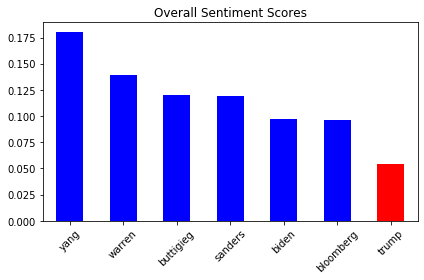

In [121]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.tight_layout()
colors = ['blue','blue','blue','blue','blue','blue','red']
candidate_sentiments['overall'].plot(kind='bar', color=colors)
plt.title('Overall Sentiment Scores')
plt.xticks(rotation='45')
plt.savefig('overall_sentiment_scores',dpi=500)

In [66]:
# dpi = 500 - put that plt.savefig('trump.jpg') function

# Trump Figures

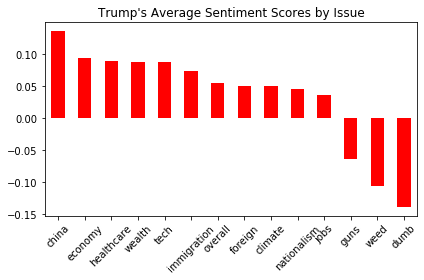

In [88]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
candidate_sentiments.iloc[0].sort_values(ascending=False).plot(kind='bar', color='red')
plt.tight_layout()
plt.title("Trump's Average Sentiment Scores by Issue")
plt.xticks(rotation='45')
plt.savefig('trump_sentiment_scores',dpi=500)

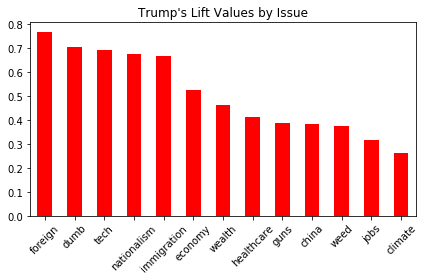

In [89]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
df_issue_lifts2.iloc[0].sort_values(ascending=False).plot(kind='bar', color='red')
plt.tight_layout()
plt.title("Trump's Lift Values by Issue")
plt.xticks(rotation='45')
plt.savefig('trump_lift_values',dpi=500)

# Dem Figures

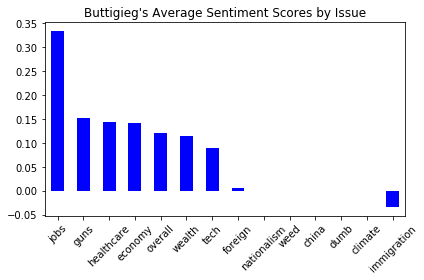

In [104]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
candidate_sentiments.iloc[6].sort_values(ascending=False).plot(kind='bar', color='blue')
plt.tight_layout()
plt.title("Buttigieg's Average Sentiment Scores by Issue")
plt.xticks(rotation='45')
plt.savefig('dem_sentiment_scores',dpi=500)

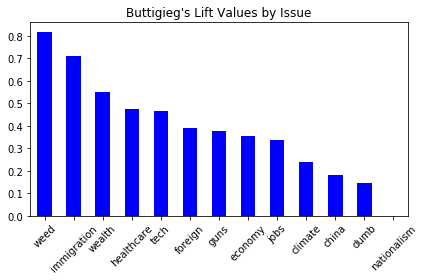

In [103]:
rcParams.update({'figure.autolayout': True})
df_issue_lifts2.iloc[6].sort_values(ascending=False).plot(kind='bar', color='blue')
plt.tight_layout()
plt.title("Buttigieg's Lift Values by Issue")
plt.xticks(rotation='45')
plt.savefig('dem_lift_values',dpi=500)